In [15]:
import sys
import os
sys.path
# sys.path.append(r'D:\Users\juanp\Documents\NeuralNetworks\final-project-landandbuildingsatimg-ccny\data\packages\image-segmentation-keras-master\image-segmentation-keras-master')
sys.path.append('../../src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import PIL # pillow - image processing
import tensorflow as tf
from PIL import Image
from tensorflow import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from models.keras_segmentation.data_utils.data_loader import get_image_array, get_segmentation_array
tf.random.set_seed(123)

# import segmentation_models as sm
# sm.set_framework('tf.keras')


# from models.keras_segmentation.models.unet import resnet50_unet, vgg_unet
# from image_segmentation.keras_segmentation.models.unet import resnet50_unet, vgg_unet
from visualization import visualize

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9  # 0.6 sometimes works better for folks
# tf.keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# bal_train_data_dir = 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train'
# bal_test_data_dir = '../../data/processed/Balanced_80/test'


out_train_data_dir = '../../data/processed/Cropped_same_name/train'
# out_val_data_dir = '../../data/processed/Cropped_same_name/val'
# out_test_data_dir = '../../data/interim/Cropped_Backup/test'

# big_im_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/raw/input/train'

In [5]:
folder_name1 ='/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/models/Save_Balanced_80_SM_JM/'
folder_name2 ='/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/models/Save_Weights_SM_JM/'

save_path1 = 'Model_Save_Model_resnet50_segnet.h5'
save_path2 = 'Model_Save_Model_vgg_segnet.h5'
save_path3 = 'Model_Save_Model_vgg_unet.h5'
save_path4 = 'Model_Save_Model_vgg_pspnet.h5'
# NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/models/Save_Balanced_80_SM_JM/Model_Save_Model_vgg_segnet.h5
# ../../models/H_models/Model_Save_Model_resnet50_segnet.h5

In [6]:
# model1 = keras.models.load_model(folder_name1 + save_path1, compile = False)
# model2 = keras.models.load_model(folder_name1 + save_path2, compile = False)
model3 = keras.models.load_model(folder_name1 + save_path3, compile = False)
# model4 = keras.models.load_model(folder_name1 + save_path4, compile = False)
# model5 = keras.models.load_model(folder_name2 + save_path1, compile = False)
# model6 = keras.models.load_model(folder_name2 + save_path2, compile = False)

In [24]:
model1.summary()
# from tensorflow.keras import models, layers

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

# Predict on Big Image With Cropping

In [7]:
img_path = '../../data/raw/input/test'

def predict(model, img, test_n = None, return_im = False, size = 512, size_out = 512):
#     test_im = sorted(glob.glob(test_path + '/Images/*'))
#     test_ms = sorted(glob.glob(test_path + '/Masks/*'))
    if test_n is None:
        test_n = 16
    x = np.zeros([test_n, size, size, 3])
    m = np.zeros([test_n, size, size])
    for i in range(test_n):
        inp = img[i,:,:,:]
#         ms = cv2.imread(test_ms[i],1)
        x[i,:,:,:] = get_image_array(inp, size, size, ordering="channels_last")
#         m[i,:,:] = get_segmentation_array(ms, 7, width = size, height = size
#                                           , no_reshape=True, read_image_type=1).argmax(axis=2)
    pred = model.predict(x)
    pred = pred.reshape((test_n, size_out,  size_out, 7)).argmax(axis=3)
    if return_im:
        return x, pred
    else:
        return pred

In [8]:
test_im = sorted(glob.glob(img_path + '/818398*'))
len(test_im)

1

In [9]:
im_n = 0

test_im = sorted(glob.glob(img_path + '/818398*'))
img =  cv2.imread(test_im[im_n],1)

In [10]:
slices = 4
sl_size = int(img.shape[0]/slices)

im_sl = np.zeros([slices**2, sl_size, sl_size, 3])
k = 0
for i in range(slices):
    for j in range(slices):
        im_sl[k,:,:,:] = img[i*sl_size:(i+1)*sl_size, j*sl_size:(j+1)*sl_size]
        k = k+1
# for i in range(k):
#     plt.figure()
#     plt.imshow(im_sl[i,:,:,:].astype(int))

In [11]:
size_out = 512
pr_b = predict(model3, im_sl, size = 512, size_out = size_out)

In [12]:
pr_big = np.zeros([size_out*4, size_out*4])
k = 0
for i in range(slices):
    for j in range(slices):
        pr_big[i*size_out:(i+1)*size_out, j*size_out:(j+1)*size_out] = pr_b[k,:,:]
        k = k+1

In [47]:
labels = pd.read_csv(f'{out_train_data_dir}/../class_dict.csv')['name'].values
col_dict = {0: 'purple', 1: 'grey', 2: 'orange', 3: 'red', 
           4: 'green', 5: 'blue', 6: 'yellow', }
labels

array(['unknown', 'urban_land', 'agriculture_land', 'rangeland',
       'forest_land', 'water', 'barren_land'], dtype=object)

In [48]:
labels2 = np.append(labels, 'building')
col_dict2 = {0: 'purple', 1: 'grey', 2: 'orange', 3: 'red', 
           4: 'green', 5: 'blue', 6: 'yellow', 7: 'black', }

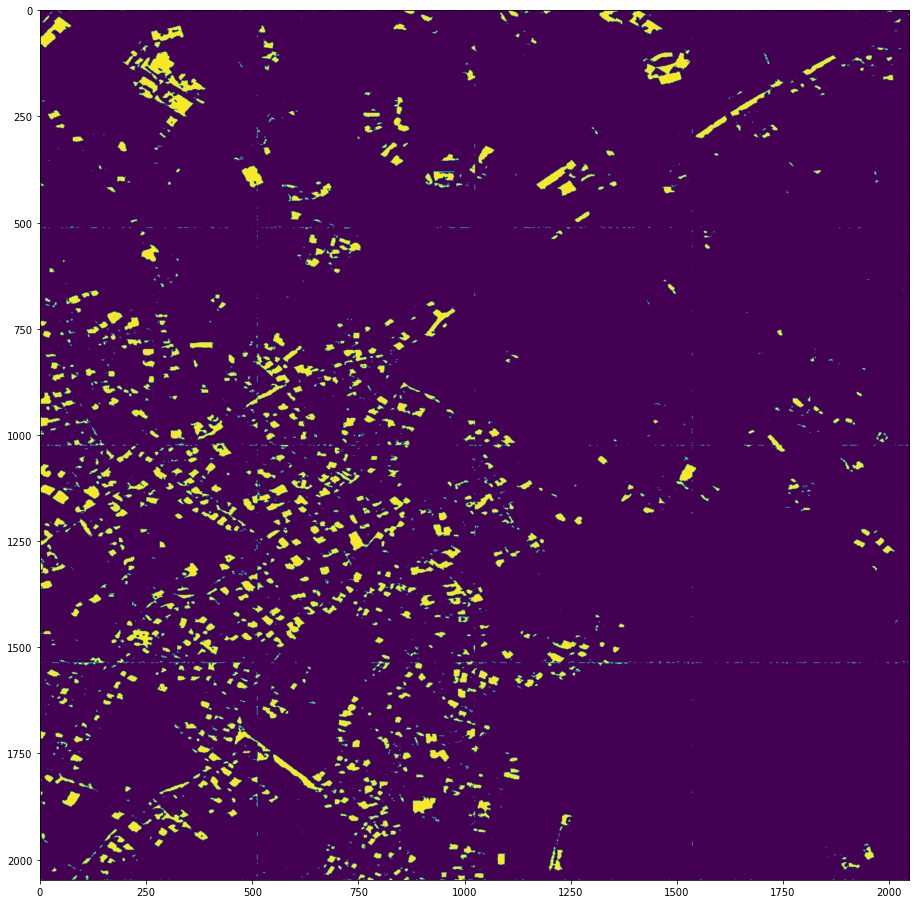

In [27]:
b = np.loadtxt(f'{out_train_data_dir}/big_data.txt', dtype=int)
fig, axes = plt.subplots(1, 1, figsize=(16, 16))
axes.imshow(b,vmin=0, vmax=1)

2048

In [31]:
b2 = np.where(b == 0, pr_big, 7)

In [66]:
from matplotlib.colors import ListedColormap

def plot_label2(mask, labels, col_dict, ax, fig, colorbar = False):
	# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
	# col_dict={1:"blue",
	#           2:"red",
	#           3:"orange",
	#           4:"green",
	#           5:"yellow",
	#           6:"purple",
	#           7:"grey"}
	# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or  using another dict maybe could help.
	# labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    
	# We create a colormar from our list of colors
	cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
	
	len_lab = len(labels)
	
	# prepare normalizer
	## Prepare bins for the normalizer
	norm_bins = np.sort([*col_dict.keys()]) + 0.5
	norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
# 	print(norm_bins)
	## Make normalizer and formatter
	norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
	fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
	
	# Plot our figure
	im = ax.imshow(mask, cmap=cm, norm=norm, interpolation = 'nearest')
    
	diff = norm_bins[1:] - norm_bins[:-1]
	tickz = norm_bins[:-1] + diff / 2
	if colorbar:
		cb = fig.colorbar(im, format=fmt, ticks=tickz)
	return im, fmt, tickz

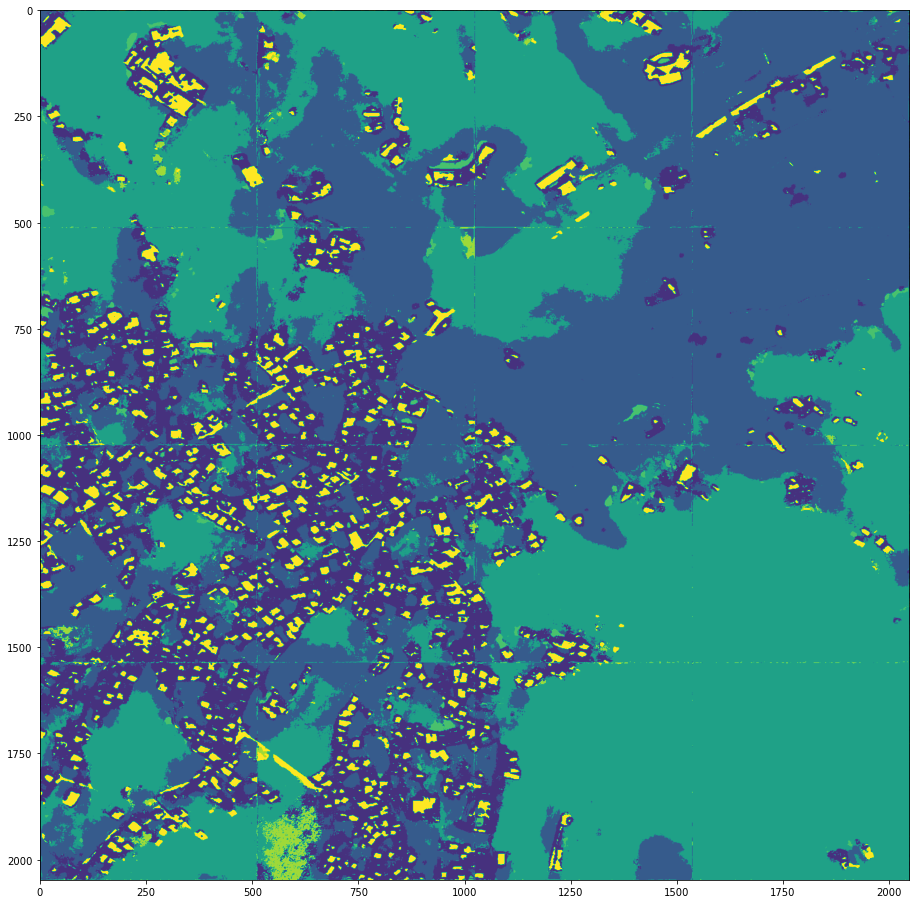

In [57]:
fig, axes = plt.subplots(figsize=(16, 16))

axes.imshow(b2)
# plt.savefig(folder_name2 + 'imgb2.png', dpi = 300)
#  'nearest'

In [80]:
np.savetxt(folder_name2 + 'land_classes.txt',pr_big)

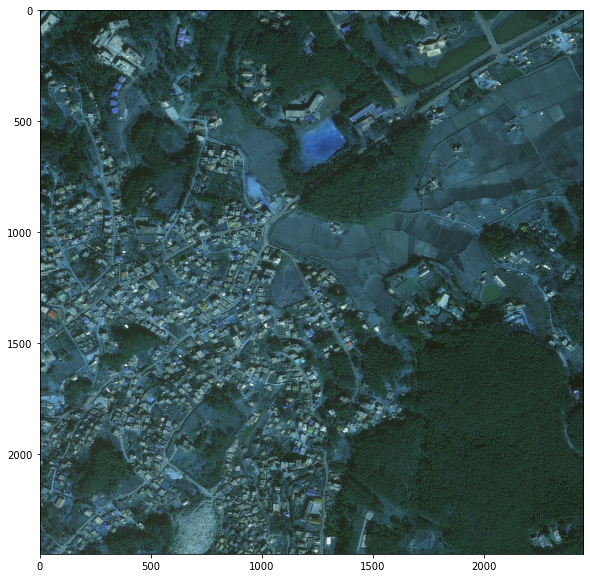

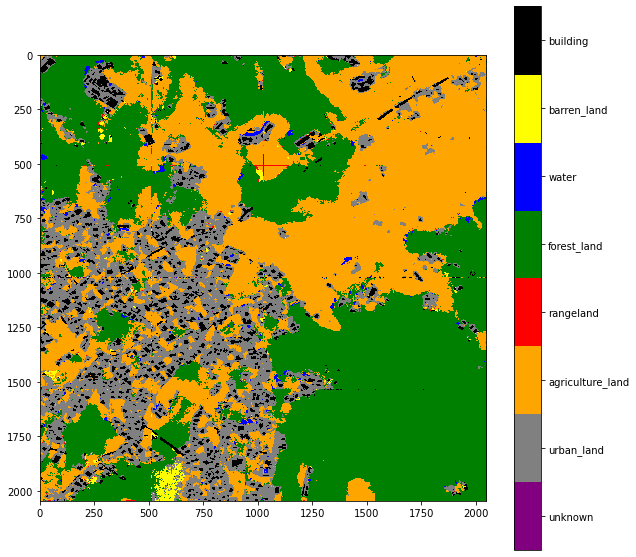

In [71]:
im_n = 0

test_im = sorted(glob.glob(img_path + '/818398*'))
img =  cv2.imread(test_im[im_n],1)


# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# fig, axes = plt.subplots(figsize=(16, 16))
# axes.imshow(img)


fig, axes = plt.subplots(figsize=(10, 10))

axes.imshow(img)
fig.savefig(folder_name2 + 'big_im_og.png', dpi = 300)

fig, axes = plt.subplots(figsize=(10, 10))
plot_label2(b2, labels2, col_dict2, axes, fig, colorbar = True)
# fig.savefig(folder_name2 + 'VGG_Unet_Bal_Big_img2_single.png', dpi = 300)